# Deep Learning for Text and Sequences

The two fundamental deep-learning algorithms for sequences processing are recurrent neural networks and 1D convnets, the one-dimensional version of 2D convnets.

Applications of these algorithms include the following:
* Document classification and timeseries classification, such as identifying the topic of an article or the author of a book
* Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are
* Sequence-to-sequence learning, such as decoding an English sentence into French
* Sentiment analysis, such as classifying the sentiment of tweets or movie reviews as positive or negative
* Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data

## Working with text data

Like all other neural networks, deep-learning models don't take as input raw text: they only work with numeric tensors. Vectorizing text is the process of transforming text into numeric tensors. This can be done in multiple ways:
* Segment text into words, and transform each word into a vector 
* Segment text into characters, and each character into a vector
* Extract n-grams of words or characters, and transform each n-gram into a vector. N-grams are overlapping groups of multiple consecutive words or characters. 

Collectively, the different units into which you can break down text (words, characters, n-grams) are called _tokens_, and breaking text into such tokens is called _tokenization_. All text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens.

### One-hot encoding of words and characters

One-hot encoding is the most common, most basic way to turn a token into a vector. It consists of associationg a unique integer index with every word and then turning this integer index i into a binary vector of size N (the size of vocabulary); the vector is all zeros except for the ith entry, which is 1. 

#### Word-level one-hot encoding

In [0]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
  for word in sample.split():
    if word not in token_index:
      token_index[word] = len(token_index) + 1
      
max_length = 10

results = np.zeros(shape=(len(samples),
                         max_length, 
                         max(token_index.values()) + 1))

for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)  
    results[i, j, index] = 1.

#### Using Keras for word-level one-hot encoding

In [2]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
# Build the word index
tokenizer.fit_on_texts(samples)

# Turn strings into lists of integer indices
sequence = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found {} unique tokerns.'.format(len(word_index)))

Using TensorFlow backend.


Found 9 unique tokerns.


### Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense word vectors, also called word embeddings. Word embeddings are low-dimenional floating-point vectors. Unlike the word vectors obtained via one-hot encoding, word embeddings are learned from data. Word embeddings pack more information into far fewer dimensions. 

| One-hot | Word embeddings |
| ----- | -----|
| Sparse | Dense |
| High-dimensional | Lower-dimensional |
| Hardcoded | Learned form data |

There are two ways to obtain word embeddings:
* Learn word embeddings jointly with the main task you care about. In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network
* Load into your model word embeddings that were precomputed using a different machine-learning task than the one you're trying to solve. These are called pretrained word embeddings. 

#### Instatntiating an `Embedding` layer

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two argumentss: 
# the number of possible tokens and 
# the dimensionality of the embeddings
embedding_layer = Embedding(1000, 64)

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. 

This layer returns a 3D floating-point tensor of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by an RNN layer or a 1D convolutional layer.

#### Loading the IMDB data for use with an Embedding layer

In [4]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut off the text after this number of words
maxlen = 20

# Load the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

# Turn  the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 3s 0us/step


#### Using an `Embedding` layer and classifie on the IMDB data

In [0]:
from keras.models import Sequential 
from keras.layers import Flatten, Dense 

model = Sequential()
# Specify the maximum input length to the Embedding later
# so you can later flatten the embedded inputs. 
# After the Embedding layer, the activations have shape (samples, mexlen, 8)
model.add(Embedding(10000, 8, input_length=maxlen))
# Flatten the 3D tensor of embeddings into a 2D tensor 
# of shape (samples, maxlen * 8)
model.add(Flatten())
# Add the classifier on top
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train, 
                   epochs=10,
                   batch_size=32, 
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 247us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 4s 202us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 4s 203us/step - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
19744/20000 [============================>.] - ETA: 0s - loss: 0.4267 - acc: 0.8077

20000/20000 [==============================] - 4s 203us/step - loss: 0.4263 - acc: 0.8077 - val_loss: 0.5008 - val_acc: 0.7452
Epoch 5/10
20000/20000 [==============================] - 4s 202us/step - loss: 0.3930 - acc: 0.8258 - val_loss: 0.4981 - val_acc: 0.7538
Epoch 6/10
20000/20000 [==============================] - 4s 197us/step - loss: 0.3668 - acc: 0.8395 - val_loss: 0.5014 - val_acc: 0.7530
Epoch 7/10
20000/20000 [==============================] - 4s 199us/step - loss: 0.3435 - acc: 0.8533 - val_loss: 0.5052 - val_acc: 0.7520
Epoch 8/10
10848/20000 [===============>..............] - ETA: 1s - loss: 0.3204 - acc: 0.8683

20000/20000 [==============================] - 4s 203us/step - loss: 0.3223 - acc: 0.8657 - val_loss: 0.5132 - val_acc: 0.7486
Epoch 9/10
20000/20000 [==============================] - 4s 202us/step - loss: 0.3022 - acc: 0.8766 - val_loss: 0.5213 - val_acc: 0.7490
Epoch 10/10
20000/20000 [==============================] - 4s 197us/step - loss: 0.2839 - acc: 0.8860 - val_loss: 0.5303 - val_acc: 0.7466


#### Using pretrained word embeddings

Sometimes, you have so little training data available that you can’t use your data alone to learn an appropriate task-specific embedding of your vocabulary. What do you do then?

Instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties—that captures generic aspects of language structure. The rationale behind using pretrained word embed- dings in natural-language processing is much the same as for using pretrained conv- nets in image classification: you don’t have enough data available to learn truly powerful features on your own, but you expect the features that you need to be fairly generic—that is, common visual features or semantic features. In this case, it makes sense to reuse features learned on a different problem.

### From raw text to word embeddings

#### Downloading the IMDB data as raw text and process the labels of the data

In [8]:
! git clone https://gitlab.com/Yuraist/ml-datasets
! rm -r ml-datasets/cats_dogs

Cloning into 'ml-datasets'...
remote: Counting objects: 87002, done.
remote: Compressing objects: 100% (86989/86989), done.
remote: Total 87002 (delta 8), reused 86993 (delta 7)
Receiving objects: 100% (87002/87002), 1.62 GiB | 4.95 MiB/s, done.
Resolving deltas: 100% (8/8), done.


Checking out files: 100% (87511/87511), done.


In [0]:
import os

imdb_dir = '/content/ml-datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

#### Tokenizing the text of the raw IMDB data

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Cut off reviews after 100 words
maxlen = 100
# Train on 200 samples
training_samples = 200
# Validate on 10,000 samples
validation_samples = 10000
# Consider only the top 10000 words in the dataset 
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set, 
# but first shufflethe data.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### Downloading the GloVe word embeddings and parsing the file

In [11]:
glove_dir = '/content/ml-datasets/pretrained/glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
  
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


#### Preparing the GloVe word-embeddings matrix

In [0]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 

#### Model definition

In [15]:
from keras.models import Sequential 
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### Loading the GloVe embeddings in the model

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### Training and evaluating the model

In [17]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32, 
                   validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.6346 - acc: 0.5300 - val_loss: 0.6938 - val_acc: 0.5043
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5977 - acc: 0.6550 - val_loss: 0.6935 - val_acc: 0.5241
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5495 - acc: 0.7650 - val_loss: 0.6986 - val_acc: 0.5446
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3602 - acc: 0.8650 - val_loss: 0.7263 - val_acc: 0.5448
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4523 - acc: 0.7850 - val_loss: 0.6933 - val_acc: 0.5613
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1387 - acc: 0.9950 - val_loss: 0.8181 - val_acc: 0.5499
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3528 - acc: 0.8600 - val_loss: 0.7255 - val_acc: 0.5700
Epoch 8/10
200/200 [========

#### Plotting the results

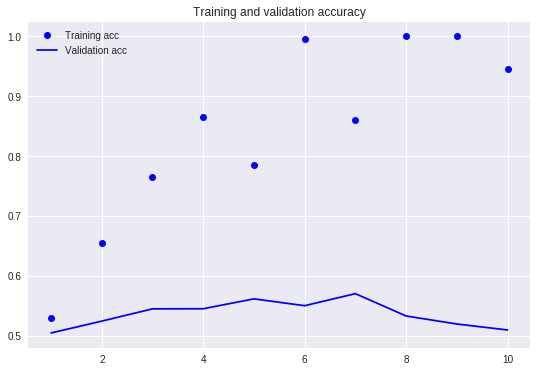

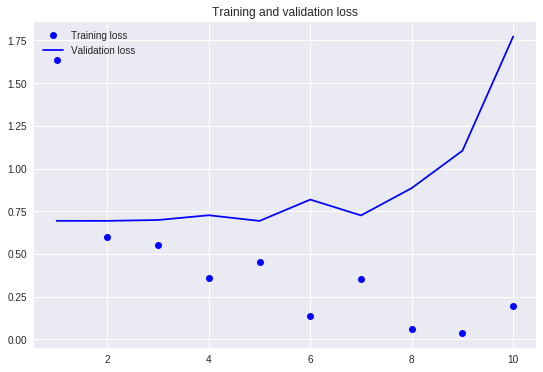

In [20]:
import matplotlib.pyplot as plt

% matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9, 6))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure(figsize=(9, 6))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You can also train the same model without loading the pretrained word embeddings and without freezing the embedding layer. In that case, you'll learn a task-specific embedding of the input tokens, which is generally more powerful that pretrained word embeddings when lots of data is available. 

#### Training the same model without pretrained word embeddings

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10, 
                   batch_size=32,
                   validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6873 - acc: 0.5150 - val_loss: 0.7006 - val_acc: 0.5236
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4776 - a

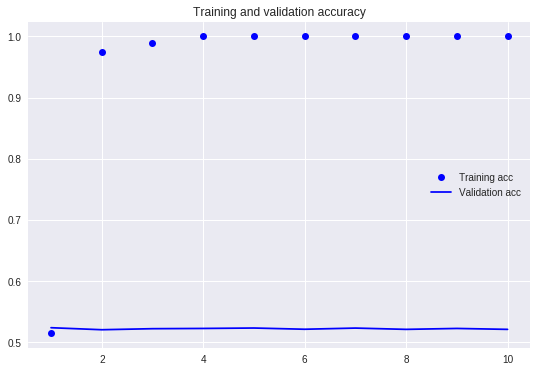

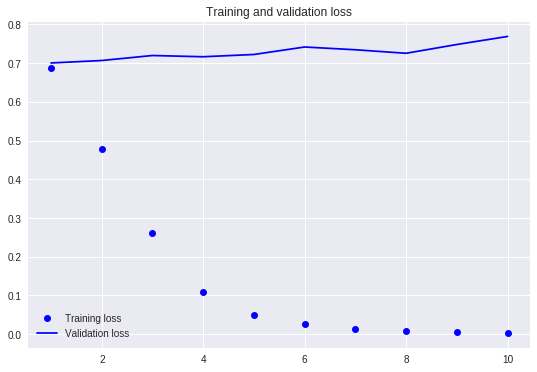

In [22]:
import matplotlib.pyplot as plt

% matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9, 6))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure(figsize=(9, 6))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Evatluating the model on the test set

In [0]:
# tokenizing the data of the test set

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)
      
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [25]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 97us/step


[1.8037889373612404, 0.50552]